# 第3章 可視化の仕組みを構築する10本ノック

In [30]:
using DataFrames
using DataFramesMeta
using CSV
using Dates
using Gadfly

## 21

In [23]:
m_store_df = CSV.read("../data/3章/m_store.csv", DataFrame)
m_area_df = CSV.read("../data/3章/m_area.csv", DataFrame)
order_data_df = CSV.read("../data/3章/tbl_order_202004.csv", DataFrame)

function assign_takeout_name(takeout_flag)
    if takeout_flag == 0
        return "デリバリー"
    elseif takeout_flag == 1
        return "お持ち帰り"
    else
        return missing
    end
end

function assign_status_name(status)
    if status == 0
        return "受付"
    elseif status == 1
        return "お支払済"
    elseif status == 2
        return "お渡し済"
    elseif status == 9
        return "キャンセル"
    else
        return missing
    end
end

order_data_df = @chain order_data_df begin
    leftjoin(m_store_df, on=[:store_id])
    leftjoin(m_area_df, on=[:area_cd])
    @rtransform begin
        :takeout_name = assign_takeout_name(:takeout_flag)
        :status_name = assign_status_name(:status)
    end
end
first(order_data_df, 10)

Row,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name
,Int64,Int64,String15,Int64,Int64,String31,String31,Int64,Int64,Int64,String31?,String3?,String15?,String15?,String,String
1,79339111,49,C26387220,50,67393872,2020-04-01 11:00:00,2020-04-01 11:18:00,1,4144,1,浅草店,TK,東京,東京,お持ち帰り,お支払済
2,18941733,85,C48773811,26,91834983,2020-04-01 11:00:00,2020-04-01 11:22:00,0,2877,2,目黒店,TK,東京,東京,デリバリー,お渡し済
3,56217880,76,C66287421,36,64409634,2020-04-01 11:00:00,2020-04-01 11:15:00,0,2603,2,本郷店,TK,東京,東京,デリバリー,お渡し済
4,28447783,190,C41156423,19,73032165,2020-04-01 11:00:00,2020-04-01 11:16:00,0,2732,2,栃木店,TO,北関東,栃木,デリバリー,お渡し済
5,32576156,191,C54568117,71,23281182,2020-04-01 11:00:00,2020-04-01 11:53:00,0,2987,2,伊勢崎店,GU,北関東,群馬,デリバリー,お渡し済
6,78384157,16,C91828823,88,38723994,2020-04-01 11:00:00,2020-04-01 11:19:00,1,2122,1,蒲田店,TK,東京,東京,お持ち帰り,お支払済
7,75031687,144,C58120290,63,82478302,2020-04-01 11:00:00,2020-04-01 11:22:00,0,2308,2,流山店,CH,千葉,千葉,デリバリー,お渡し済
8,83880121,77,C08085038,0,63603896,2020-04-01 11:00:00,2020-04-01 11:25:00,0,2112,2,大塚店,TK,東京,東京,デリバリー,お渡し済
9,26741317,22,C24382968,72,44038720,2020-04-01 11:00:00,2020-04-01 11:15:00,1,3120,9,国立店,TK,東京,東京,お持ち帰り,キャンセル


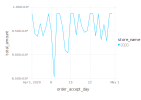

In [34]:
@chain order_data_df begin
    @select(:order_accept_date, :store_name, :total_amount)
    @rsubset(:store_name == "北千住店")
    @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
    @rtransform(:order_accept_day = Date(:order_accept_date))
    groupby([:order_accept_day, :store_name])
    @combine(:total_amount = sum(:total_amount))
    plot(x = :order_accept_day, y = :total_amount, color = :store_name, Geom.line())
end

In [36]:
function draw_(order_data_df, store_name)
    @chain order_data_df begin
        @select(:order_accept_date, :store_name, :total_amount)
        @rsubset(:store_name == store_name)
        @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
        @rtransform(:order_accept_day = Date(:order_accept_date))
        groupby([:order_accept_day, :store_name])
        @combine(:total_amount = sum(:total_amount))
        plot(x = :order_accept_day, y = :total_amount, color = :store_name, Geom.line())
    end
end

draw_ (generic function with 2 methods)

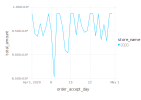

In [37]:
draw_(order_data_df, "北千住店")

## 22

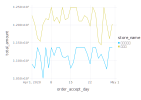

In [38]:
@chain order_data_df begin
    @select(:order_accept_date, :store_name, :total_amount)
    @rsubset(:store_name in ["昭島店", "あきる野店"])
    @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
    @rtransform(:order_accept_day = Date(:order_accept_date))
    groupby([:order_accept_day, :store_name])
    @combine(:total_amount = sum(:total_amount))
    plot(x = :order_accept_day, y = :total_amount, color = :store_name, Geom.line())
end

## 23

In [40]:
@chain order_data_df begin
    @select(:store_name)
    groupby([:store_name])
    @combine(:size = length(:store_name))
    @rsubset(1000 > :size)
end

Row,store_name,size
,String31?,Int64
1,本郷店,735
2,西葛西店,792
3,東久留米店,854
4,茅ヶ崎店,886
5,越谷店,885
6,前橋店,821
7,銀座店,967
8,西東京店,968
9,足立店,848


In [41]:
@chain order_data_df begin
    @select(:store_name)
    groupby([:store_name])
    @combine(:size = length(:store_name))
    @rsubset(1500 < :size)
end

Row,store_name,size
,String31?,Int64
1,伊勢崎店,1581
2,西多摩店,1534
3,八王子店,1524
4,綾瀬店,2607
5,世田谷店,1537
6,上野店,1609
7,三鷹店,1505
8,谷中店,1503
9,栄店,1534


## 24

In [43]:
@chain order_data_df begin
    @rsubset(:status in [1, 2])
    # @rsubset(:wide_area in ["東京"])
    groupby(:wide_area)
end

Row,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name
,Int64,Int64,String15,Int64,Int64,String31,String31,Int64,Int64,Int64,String31?,String3?,String15?,String15?,String,String
1,79339111,49,C26387220,50,67393872,2020-04-01 11:00:00,2020-04-01 11:18:00,1,4144,1,浅草店,TK,東京,東京,お持ち帰り,お支払済
2,18941733,85,C48773811,26,91834983,2020-04-01 11:00:00,2020-04-01 11:22:00,0,2877,2,目黒店,TK,東京,東京,デリバリー,お渡し済
3,56217880,76,C66287421,36,64409634,2020-04-01 11:00:00,2020-04-01 11:15:00,0,2603,2,本郷店,TK,東京,東京,デリバリー,お渡し済
4,78384157,16,C91828823,88,38723994,2020-04-01 11:00:00,2020-04-01 11:19:00,1,2122,1,蒲田店,TK,東京,東京,お持ち帰り,お支払済
5,83880121,77,C08085038,0,63603896,2020-04-01 11:00:00,2020-04-01 11:25:00,0,2112,2,大塚店,TK,東京,東京,デリバリー,お渡し済
6,91778351,63,C67537445,60,12134062,2020-04-01 11:00:00,2020-04-01 11:10:00,0,3050,2,西多摩店,TK,東京,東京,デリバリー,お渡し済
7,49844959,60,C67628236,88,70561273,2020-04-01 11:00:00,2020-04-01 11:55:00,0,3120,2,駒込店,TK,東京,東京,デリバリー,お渡し済
8,99659397,63,C01573544,91,93591528,2020-04-01 11:00:00,2020-04-01 11:47:00,0,2154,2,西多摩店,TK,東京,東京,デリバリー,お渡し済
9,69947210,19,C49493871,95,94729238,2020-04-01 11:00:00,2020-04-01 12:05:00,0,3190,2,赤羽店,TK,東京,東京,デリバリー,お渡し済


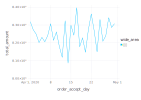

In [48]:
@chain order_data_df begin
    @rsubset(:status in [1, 2])
    @rsubset(:wide_area in ["東京"])
    @select(:order_accept_date, :wide_area, :total_amount)
    @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
    @rtransform(:order_accept_day = Date(:order_accept_date))
    groupby([:order_accept_day, :wide_area])
    @combine(:total_amount = sum(:total_amount))
    plot(x = :order_accept_day, y = :total_amount, color = :wide_area, Geom.line())
end

## 25

In [50]:
@chain order_data_df begin
    @rsubset(:status in [1, 2])
    @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
    @rtransform(:order_accept_day = Date(:order_accept_date))
    @rsubset(:order_accept_day == Date(2020, 4, 16))
end

Row,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name,order_accept_day
,Int64,Int64,String15,Int64,Int64,DateTime,String31,Int64,Int64,Int64,String31?,String3?,String15?,String15?,String,String,Date
1,15033819,16,C17937252,95,67711155,2020-04-16T11:00:00,2020-04-16 11:57:00,0,2238,2,蒲田店,TK,東京,東京,デリバリー,お渡し済,2020-04-16
2,53990363,90,C43339908,75,8053044,2020-04-16T11:00:00,2020-04-16 11:35:00,0,2603,2,綾瀬店,KN,神奈川,神奈川,デリバリー,お渡し済,2020-04-16
3,55811234,66,C69559846,8,91627509,2020-04-16T11:00:00,2020-04-16 12:15:00,0,3234,2,石神井店,TK,東京,東京,デリバリー,お渡し済,2020-04-16
4,59981543,67,C64079015,38,58776243,2020-04-16T11:00:00,2020-04-16 11:31:00,0,2677,2,大泉店,TK,東京,東京,デリバリー,お渡し済,2020-04-16
5,55202430,49,C68922555,28,37306695,2020-04-16T11:00:00,2020-04-16 11:15:00,1,2328,1,浅草店,TK,東京,東京,お持ち帰り,お支払済,2020-04-16
6,86770933,174,C03238244,69,29283062,2020-04-16T11:00:00,2020-04-16 11:14:00,0,4624,2,新座店,SA,埼玉,埼玉,デリバリー,お渡し済,2020-04-16
7,98083052,61,C49862944,65,3238726,2020-04-16T11:00:00,2020-04-16 11:28:00,0,2312,2,中野店,TK,東京,東京,デリバリー,お渡し済,2020-04-16
8,40591369,59,C29765785,69,61551192,2020-04-16T11:00:00,2020-04-16 11:36:00,0,3502,2,巣鴨店,TK,東京,東京,デリバリー,お渡し済,2020-04-16
9,92271102,175,C69544168,5,27869382,2020-04-16T11:00:00,2020-04-16 11:21:00,0,2238,2,羽生店,SA,埼玉,埼玉,デリバリー,お渡し済,2020-04-16


In [51]:
@chain order_data_df begin
    @rsubset(:status in [1, 2])
    @rtransform(:order_accept_date = DateTime(:order_accept_date, dateformat"yyyy-mm-dd HH:MM:SS"))
    @rtransform(:order_accept_day = Date(:order_accept_date))
    @rsubset(Date(2020, 4, 1) <= :order_accept_day <= Date(2020, 4, 16))
end

Row,order_id,store_id,customer_id,coupon_cd,sales_detail_id,order_accept_date,delivered_date,takeout_flag,total_amount,status,store_name,area_cd,wide_area,narrow_area,takeout_name,status_name,order_accept_day
,Int64,Int64,String15,Int64,Int64,DateTime,String31,Int64,Int64,Int64,String31?,String3?,String15?,String15?,String,String,Date
1,79339111,49,C26387220,50,67393872,2020-04-01T11:00:00,2020-04-01 11:18:00,1,4144,1,浅草店,TK,東京,東京,お持ち帰り,お支払済,2020-04-01
2,18941733,85,C48773811,26,91834983,2020-04-01T11:00:00,2020-04-01 11:22:00,0,2877,2,目黒店,TK,東京,東京,デリバリー,お渡し済,2020-04-01
3,56217880,76,C66287421,36,64409634,2020-04-01T11:00:00,2020-04-01 11:15:00,0,2603,2,本郷店,TK,東京,東京,デリバリー,お渡し済,2020-04-01
4,28447783,190,C41156423,19,73032165,2020-04-01T11:00:00,2020-04-01 11:16:00,0,2732,2,栃木店,TO,北関東,栃木,デリバリー,お渡し済,2020-04-01
5,32576156,191,C54568117,71,23281182,2020-04-01T11:00:00,2020-04-01 11:53:00,0,2987,2,伊勢崎店,GU,北関東,群馬,デリバリー,お渡し済,2020-04-01
6,78384157,16,C91828823,88,38723994,2020-04-01T11:00:00,2020-04-01 11:19:00,1,2122,1,蒲田店,TK,東京,東京,お持ち帰り,お支払済,2020-04-01
7,75031687,144,C58120290,63,82478302,2020-04-01T11:00:00,2020-04-01 11:22:00,0,2308,2,流山店,CH,千葉,千葉,デリバリー,お渡し済,2020-04-01
8,83880121,77,C08085038,0,63603896,2020-04-01T11:00:00,2020-04-01 11:25:00,0,2112,2,大塚店,TK,東京,東京,デリバリー,お渡し済,2020-04-01
9,91778351,63,C67537445,60,12134062,2020-04-01T11:00:00,2020-04-01 11:10:00,0,3050,2,西多摩店,TK,東京,東京,デリバリー,お渡し済,2020-04-01
